In [10]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import json
import random
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
from torchvision.models import resnet50, ResNet50_Weights

### Patch

torch.Size([1, 3, 224, 224])
ballplayer


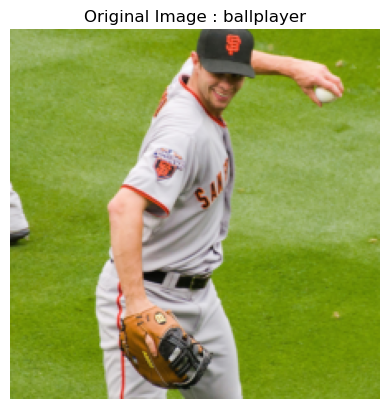

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1).to(device)
model.eval()

class_idx = json.load(open("../data/imagenet_class_index.json"))
idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]

input_image= "../data/person.jpg"

image = Image.open(input_image).convert("RGB")

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor()
])

image_tensor = preprocess(image).unsqueeze(0).to(device)

print(image_tensor.shape)

output = model(image_tensor)

_, predict = torch.max(output,1)

labels = idx2label[predict.item()]

print(labels)

original_image = image_tensor.squeeze(0).permute(1,2,0).detach().cpu().numpy()
original_image = np.clip(original_image, 0, 1)

plt.imshow(original_image)
plt.axis("off")
plt.title(f"Original Image : {labels}")
plt.show()

In [12]:
def random_transformation(image, patch, patch_size, max_rotation=30):
    
    image_size = image.shape[-2:]
    
    patch_location = (random.randint(0, image_size[0]-patch_size[0]),
                      random.randint(0, image_size[1]-patch_size[1]))

    # 랜덤 회전
    angle = random.uniform(-max_rotation, max_rotation)
    patch_rotated = TF.rotate(patch, angle)

    # 이미지에 패치 적용
    patched_image = image.clone()
    patched_image[:, :, patch_location[0]:patch_location[0]+patch_size[0], patch_location[1]:patch_location[1]+patch_size[1]] = patch_rotated
    
    return patched_image

def patch_generate(input, iterations, learning_rate, patch_size, patch_location, target_class):

    patch = torch.rand(1,3,patch_size[0],patch_size[1], requires_grad=True)
    optimizer = optim.Adam([patch], learning_rate)

    for i in tqdm(range(iterations), desc="generating patch"):
        
        patched_image = random_transformation(input, patch, patch_size)

        output = model(patched_image)
        loss = -output[0, target_class]

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return patched_image

iterations = 500
learning_rate = 0.01
patch_size = (50, 50)
patch_location = (20, 20)
target_class = 1

patched_image = patch_generate(image_tensor, iterations, learning_rate, patch_size, patch_location, target_class)

generating patch: 100%|██████████| 500/500 [00:06<00:00, 75.19it/s]


In [13]:
print(patched_image.shape)

adversarial_output = model(patched_image)
_, adversarial_labels = torch.max(adversarial_output, 1)
adversarial_labels = idx2label[adversarial_labels.item()]

print(adversarial_labels)

torch.Size([1, 3, 224, 224])
torch


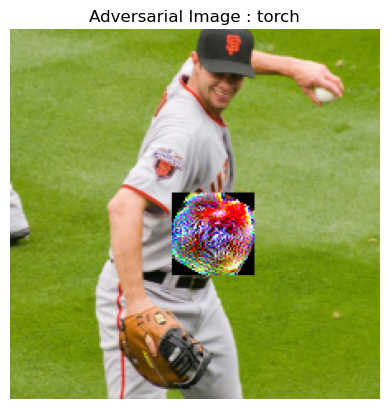

In [14]:
adversarial_image = patched_image.squeeze(0).permute(1,2,0).detach().cpu().numpy()
adversarial_image = np.clip(adversarial_image, 0, 1)

plt.imshow(adversarial_image)
plt.axis("off")
plt.title(f"Adversarial Image : {adversarial_labels}")
plt.show()